In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import bochamm
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import numpy.matlib
import pandas as pd
import scipy.stats as stats
import time
import time as timer


from astropy.timeseries import LombScargle
from scipy.stats import qmc
from sloscillations import frequencies, mixed_modes_utils
#from tqdm import tqdm
#from taco.rotation import rotation_utils
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from turbo import Turbo1, TurboM
from turbo.utils import from_unit_cube, latin_hypercube, to_unit_cube
from typing import Optional

from joblib import Parallel, delayed
from tqdm import tqdm

## Loading in the data

To start with we're going to use a fast rotating star KIC 8564976 (a.k.a KOI-3890). This may seem counter intuitive since going for a complicated case straight away does not seem wise, but all will become clear a little later.

In [129]:
fnames = glob.glob("*cluster_results.txt")

In [130]:
kics = [int(i.split('_')[0]) for i in fnames]

In [142]:
df = pd.DataFrame(columns=['KIC', 
                           'best_DPi1', 'best_q', 'intial_DPi1', 'initial_DPi1_power', 
                           'cluster_DPi1_l', 'cluster_DPi1', 'cluster_DPi1_u', 'cluster_q_l', 'cluster_q', 'cluster_q_u',
                           'cluster_loss'])#,
                           #'thresh_DPi1_l', 'thresh_DPi1_u', 'thresh_q_l', 'thresh_q_u',
                           #'thresh_loss'])
for i in range(len(fnames)):
    #print(fnames[i])
    tmp = []
    kic = fnames[i].split('_')[0]
    best_results = np.loadtxt(f"{kic}_best.txt")
    tmp = np.append(tmp, int(kic))
    tmp = np.append(tmp, best_results)
    data = np.loadtxt(fnames[i])
    if data.shape[0] == 2:
        tmp = np.append(tmp, data[0,1:4])
        tmp = np.append(tmp, data[1,1:4])
        tmp = np.append(tmp, data[0,-1])
    elif data.shape[0] > 2:
#        print(data)
        n_clusters = data.shape[0]//2
#        print(n_clusters)
        best_clusters = np.argmin(data[:n_clusters,-n_clusters:])
        #print(data[:n_clusters,:][best_clusters,:])
        tmp = np.append(tmp, data[:n_clusters,:][best_clusters,1:4])
        tmp = np.append(tmp, data[n_clusters:,:][best_clusters,1:4])
        tmp = np.append(tmp, data[:n_clusters,:][best_clusters,-(n_clusters - best_clusters)])
        # print(data[:n_clusters,:][best_clusters,:])
        # print(data[:n_clusters,:][best_clusters,-(best_clusters+1)])
        # print(best_clusters)
        # print("*"*100)

    else:
        print("OH DEAR")
    #print(tmp)
    df.loc[len(df.index)+1] = tmp

In [143]:
df['KIC']  = df['KIC'].astype(int)

In [144]:
mosser = pd.read_csv('../tables/Mosser_2018.dat', delimiter=r'\s+')

In [146]:
joined = pd.merge(df, mosser, how='inner', on=['KIC'])

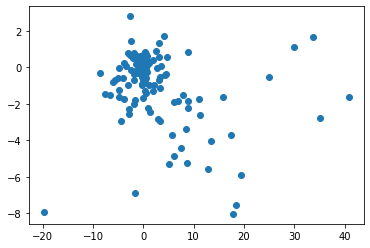

In [154]:
plt.scatter(joined['intial_DPi1']-joined['best_DPi1'], joined['cluster_loss']-(-joined['initial_DPi1_power']*1e3))

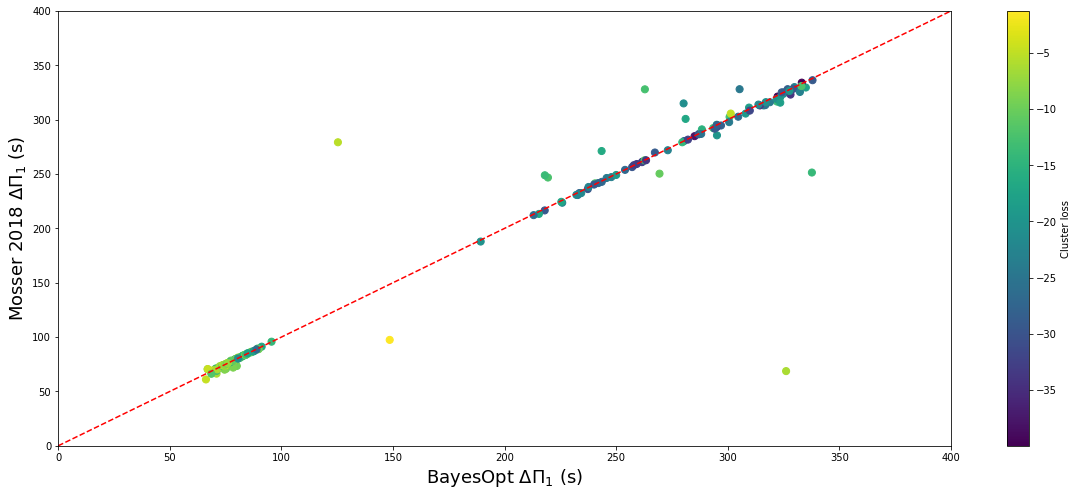

In [147]:
plt.figure(figsize=(20,8))
x = np.linspace(0, 400, 1000)
# plt.errorbar(joined['cluster_DPi1'], joined['dpi'], 
#              xerr=[joined['cluster_DPi1']-joined['cluster_DPi1_l'], joined['cluster_DPi1_u']-joined['cluster_DPi1']], 
#              yerr=[joined['e_dpi']], fmt='.', color='k')
plt.scatter(joined['best_DPi1'], joined['dpi'], c=joined['cluster_loss'], s=50)
plt.plot(x, x, color='r', linestyle='--')
plt.xlabel(r"BayesOpt $\Delta\Pi_{1}$ (s)", fontsize=18)
plt.ylabel(r"Mosser 2018 $\Delta\Pi_{1}$ (s)", fontsize=18)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.colorbar(label=r'Cluster loss')

(0.0, 0.8)

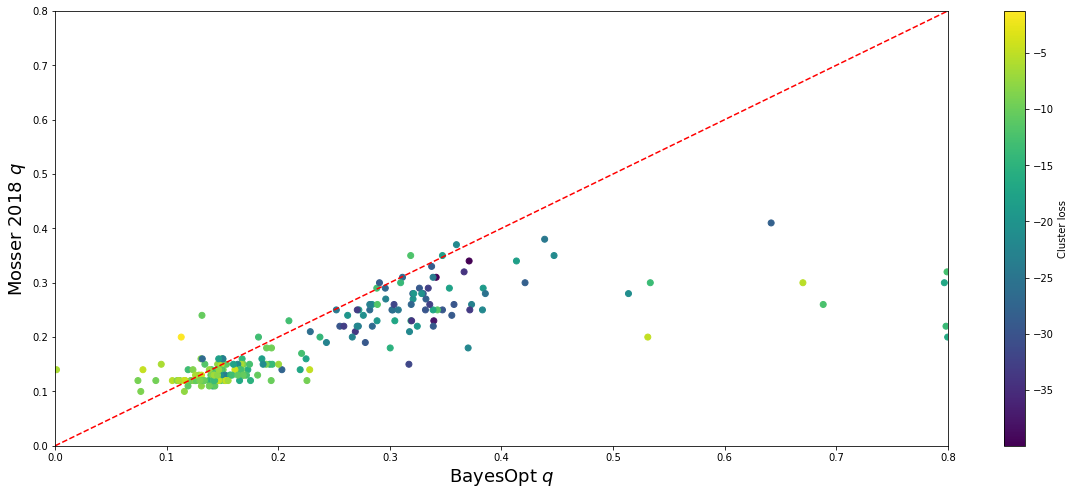

In [148]:
plt.figure(figsize=(20,8))
x = np.linspace(0, 0.8, 1000)
plt.scatter(joined['best_q'], joined['q'], c=joined['cluster_loss'], zorder=1)
plt.plot(x, x, color='r', linestyle='--')
plt.xlabel(r"BayesOpt $q$", fontsize=18)
plt.ylabel(r"Mosser 2018 $q$", fontsize=18)
plt.colorbar(label=r'Cluster loss')
plt.xlim(0, 0.8)
plt.ylim(0, 0.8)

In [145]:
joined['diff'] = joined['dpi']-joined['cluster_DPi1']

In [135]:
joined.loc[np.abs(joined['diff']/joined['dpi']) > 0.1, ]

,KIC,cluster_DPi1_l,cluster_DPi1,cluster_DPi1_u,cluster_q_l,cluster_q,cluster_q_u,cluster_loss,numax,e_numax,...,e_dnu,dpi,e_dpi,q,e_q,eps_g,e_eps_g,rot,e_rot,diff
10,1162746,125.227857,125.345469,125.459902,0.603337,0.621565,0.659688,-5.193850,27.18,0.48,...,0.04,279.19,0.12,0.30,0.04,0.020,0.061,65,12,153.844531
46,2305479,332.063707,332.634368,333.363358,0.763227,0.789212,0.796908,-6.211745,79.08,0.97,...,0.04,68.71,0.02,0.14,0.02,-0.182,0.052,350,13,-263.924368
83,2987113,218.989670,219.307551,219.524169,0.518562,0.630957,0.722691,-12.328930,33.60,0.48,...,0.03,246.75,0.14,0.26,0.03,-0.059,0.076,30,7,27.442449
106,3217051,279.750247,280.147960,280.404482,0.479701,0.523209,0.592276,-20.989472,36.20,0.53,...,0.03,314.93,0.23,0.28,0.03,-0.144,0.070,45,11,34.782040
119,3241374,337.620015,337.933017,338.396891,0.282170,0.322211,0.378355,-14.007983,37.60,0.53,...,0.03,251.35,0.16,0.30,0.03,-0.029,0.074,30,7,-86.583017
126,3425476,243.142669,243.400885,243.630659,0.655049,0.694227,0.772258,-16.445546,39.80,0.56,...,0.04,271.13,0.13,0.20,0.03,0.040,0.050,30,7,27.729115
127,3425675,262.514822,262.811409,263.050801,0.718375,0.768446,0.790881,-12.722464,31.80,0.51,...,0.04,327.89,0.29,0.32,0.04,-0.309,0.093,30,7,65.078591
136,3526995,217.761461,218.019944,218.262630,0.680202,0.758341,0.785798,-13.782722,34.60,0.52,...,0.04,248.84,0.13,0.22,0.03,0.011,0.065,30,7,30.820056
158,3744681,237.106113,237.787520,238.128901,0.550304,0.615571,0.699871,-15.251948,61.94,0.71,...,0.04,291.06,0.41,0.18,0.02,-0.001,0.088,110,22,53.272480
163,4351319,148.397268,148.671324,149.110133,0.099213,0.122627,0.170983,-1.247118,385.27,5.64,...,0.10,97.41,0.15,0.20,0.02,0.333,0.039,260,24,-51.261324


In [136]:
joined.loc[joined['KIC'] == 3749487, ]

,KIC,cluster_DPi1_l,cluster_DPi1,cluster_DPi1_u,cluster_q_l,cluster_q,cluster_q_u,cluster_loss,numax,e_numax,...,e_dnu,dpi,e_dpi,q,e_q,eps_g,e_eps_g,rot,e_rot,diff
159,3749487,68.432661,68.528824,68.614404,0.100689,0.122667,0.162651,-5.83431,69.98,0.84,...,0.04,68.0,0.02,0.12,0.02,-0.313,0.077,120,11,-0.528824


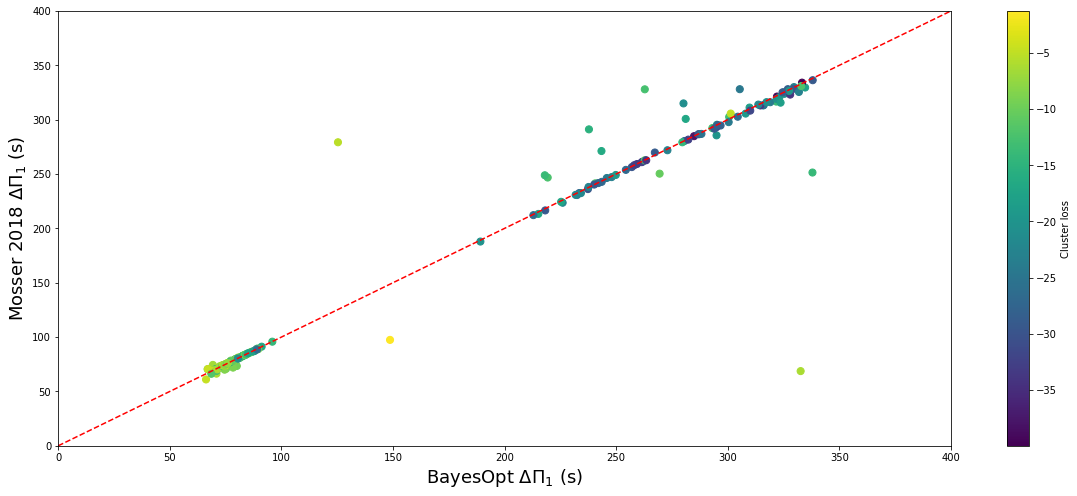

In [137]:
plt.figure(figsize=(20,8))
x = np.linspace(0, 400, 1000)
# plt.errorbar(joined['cluster_DPi1'], joined['dpi'], 
#              xerr=[joined['cluster_DPi1']-joined['cluster_DPi1_l'], joined['cluster_DPi1_u']-joined['cluster_DPi1']], 
#              yerr=[joined['e_dpi']], fmt='.', color='k')
plt.scatter(joined['cluster_DPi1'], joined['dpi'], c=joined['cluster_loss'], s=50)
plt.plot(x, x, color='r', linestyle='--')
plt.xlabel(r"BayesOpt $\Delta\Pi_{1}$ (s)", fontsize=18)
plt.ylabel(r"Mosser 2018 $\Delta\Pi_{1}$ (s)", fontsize=18)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.colorbar(label=r'Cluster loss')

Text(0, 0.5, 'Mosser 2018 $\\Delta\\Pi_{1}$ - BayesOpt $\\Delta\\Pi_{1}$ (s)')

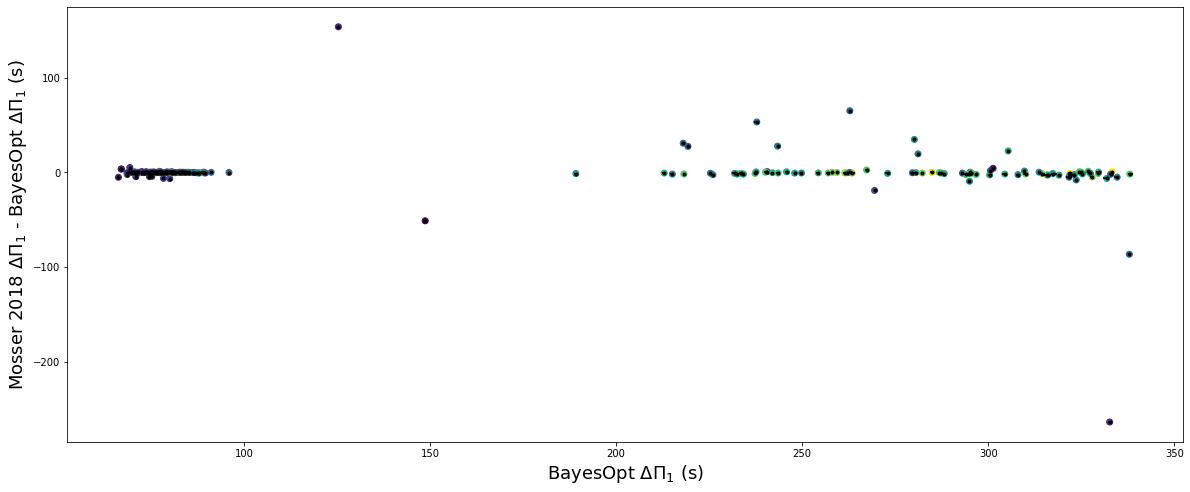

In [138]:
plt.figure(figsize=(20,8))
x = np.linspace(0, 0, 1000)
plt.errorbar(joined['cluster_DPi1'], joined['dpi']-joined['cluster_DPi1'], 
             xerr=[joined['cluster_DPi1']-joined['cluster_DPi1_l'], joined['cluster_DPi1_u']-joined['cluster_DPi1']], 
             yerr=[joined['e_dpi']], fmt='.', color='k')
plt.scatter(joined['cluster_DPi1'], joined['dpi']-joined['cluster_DPi1'], c=-joined['cluster_loss'])
#plt.plot(x, x, color='r', linestyle='--')
#plt.ylim(-10, 10)
#plt.xlim(50, 100)
plt.xlabel(r"BayesOpt $\Delta\Pi_{1}$ (s)", fontsize=18)
plt.ylabel(r"Mosser 2018 $\Delta\Pi_{1}$ - BayesOpt $\Delta\Pi_{1}$ (s)", fontsize=18)
#plt.colorbar()

(0.0, 0.8)

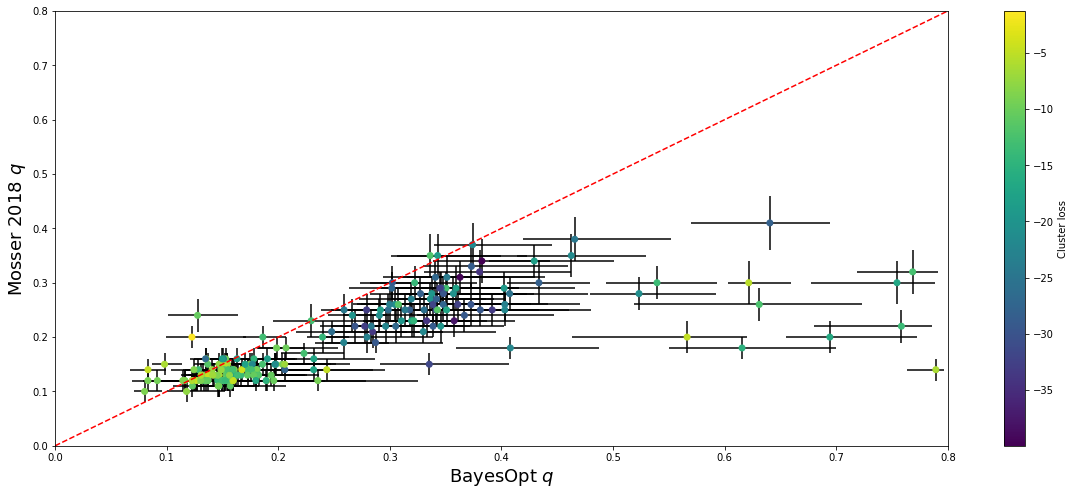

In [139]:
plt.figure(figsize=(20,8))
x = np.linspace(0, 0.8, 1000)
plt.errorbar(joined['cluster_q'], joined['q'], 
             xerr=[joined['cluster_q']-joined['cluster_q_l'], joined['cluster_q_u']-joined['cluster_q']], 
             yerr=[joined['e_q']], fmt='.', color='k', zorder=-1)
plt.scatter(joined['cluster_q'], joined['q'], c=joined['cluster_loss'], zorder=1)
plt.plot(x, x, color='r', linestyle='--')
plt.xlabel(r"BayesOpt $q$", fontsize=18)
plt.ylabel(r"Mosser 2018 $q$", fontsize=18)
plt.colorbar(label=r'Cluster loss')
plt.xlim(0, 0.8)
plt.ylim(0, 0.8)